In [22]:
import numpy as np
import pandas as pd
from scipy.sparse import issparse
from pathlib import Path
import scanpy as sc
import geopandas as gpd
from sklearn_ann.kneighbors.annoy import AnnoyTransformer


TODO:

1. Test out the Annoy kNN - https://scanpy.readthedocs.io/en/stable/how-to/knn-transformers.html
2. Test other covariate metrics (definitely cell cycle scores)
    - Percent ribosomal reads (e.g. % ribo = var_names.str.startswith('RPS|RPL'))
           - No ribosomal genes detected
    - Cell cycle scores (G2M/S scores calculated via sc.tl.score_genes_cell_cycle) if you think cell‐cycle is obscuring your clusters
    - Segmentation‐derived metrics, e.g. nucleus area, eccentricity, or perimeter from your GeoDataFrame if you suspect morphology drives artifactual signal
    - Don’t regress out anything you want to cluster on (e.g., spatial coordinates, known biology, batch ID if you plan to study batch effects separately).
    - Create a regression for Myc Cap genes and PTEN scores
    - DNA repair genes as well

In [23]:
# Define path
sample_id = "F07833"
segmentation_path = Path(
    "/mnt/c/Users/jonan/Documents/1Work/RoseLab/Spatial/"
    "dietary_droject/data/cell_segmentation/SegmentedData"
)
adata_path = segmentation_path / sample_id / f"{sample_id}_grouped_filtered_adata.h5ad"

# Load AnnData
ST_sample = sc.read_h5ad(adata_path)

# Load geo data
GDF_file = Path("/mnt/c/Users/jonan/Documents/1Work/RoseLab/Spatial/dietary_droject/data/cell_segmentation/SegmentedData/F07833/F07833_gdf.gpkg")
geo_file = gpd.read_file(GDF_file)

In [24]:
# Identify mitochondrial genes (prefix 'MT-' for human)
ST_sample.var['mito'] = ST_sample.var_names.str.startswith('mt-')

#  Run QC metrics
sc.pp.calculate_qc_metrics(
    ST_sample, 
    qc_vars=['mito'], 
    inplace=True, 
    log1p=False
)


In [25]:
sc.pp.filter_cells(ST_sample, min_counts=30)
sc.pp.filter_genes(ST_sample, min_cells=3)
ST_sample = ST_sample[
    (ST_sample.obs['total_counts'] >= 50) &
    (ST_sample.obs['pct_counts_mito'] <= 15)
].copy()

In [26]:
sc.pp.normalize_total(ST_sample, target_sum=1e4)
sc.pp.log1p(ST_sample)
sc.pp.highly_variable_genes(ST_sample, n_top_genes=2000, subset=True)

In [27]:
# Load your mouse S/G2M lists from JSON

outdir = "/mnt/c/Users/jonan/Documents/1Work/RoseLab/Spatial/dietary_droject/data/cell_typing_reference_from_pc/Gene_lists"
with open(f"{outdir}/cc_mouse_cycle_genes.json") as jf:
    cc = json.load(jf)
s_genes_mouse  = cc["s_genes"]
g2m_genes_mouse = cc["g2m_genes"]

# Scoring for S and g2m phases

sc.tl.score_genes_cell_cycle(
    ST_sample,
    s_genes   = s_genes_mouse,
    g2m_genes = g2m_genes_mouse,
    use_raw   = False   # if you have raw counts stored, you can set True
)


       'Dtl', 'Exo1', 'Fen1', 'Gins2', 'Gmnn', 'Hells', 'Mcm4', 'Mcm5', 'Mcm7',
       'Mrpl36', 'Msh2', 'Nasp', 'Pola1', 'Polr1b', 'Prim1', 'Rad51',
       'Rad51ap1', 'Rfc2', 'Rrm1', 'Slbp', 'Tipin', 'Tyms', 'Ubr7', 'Uhrf1',
       'Ung', 'Usp1', 'Wdr76'],
      dtype='object')
       'Cdc25c', 'Cdca2', 'Cdca3', 'Cdk1', 'Cenpa', 'Cenpe', 'Ckap2', 'Ckap5',
       'Cks1b', 'Dlgap5', 'Ect2', 'Gas2l3', 'Gtse1', 'Hjurp', 'Hmgb2', 'Hmmr',
       'Jpt1', 'Kif11', 'Kif20b', 'Kif23', 'Kif2c', 'Lbr', 'Mki67', 'Ncapd2',
       'Nek2', 'Nuf2', 'Nusap1', 'Pimreg', 'Psrc1', 'Rangap1', 'Smc4', 'Tmpo',
       'Top2a', 'Tpx2', 'Ttk', 'Tubb4b', 'Ube2c'],
      dtype='object')


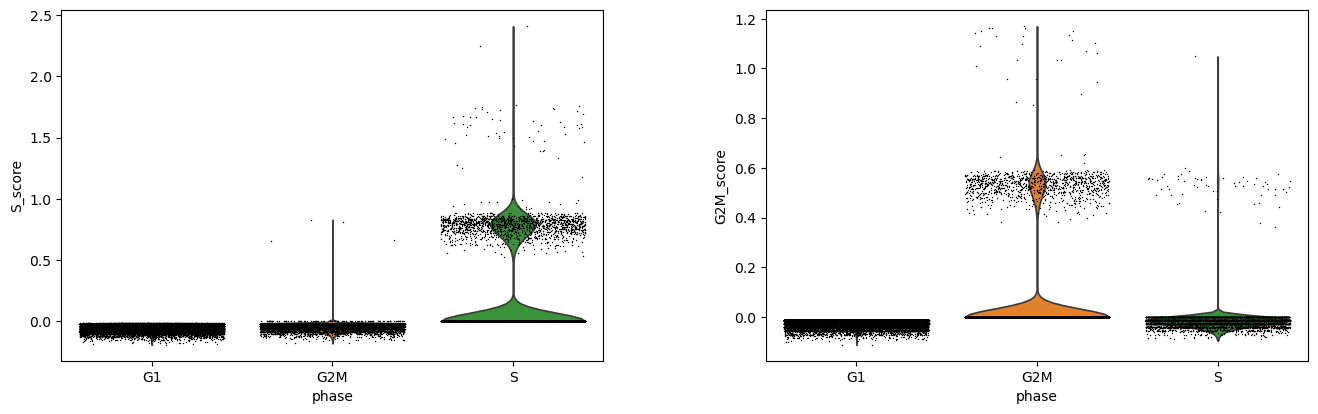

In [28]:
sc.pl.violin(ST_sample, ['S_score','G2M_score'], groupby='phase', jitter=0.4)
# sc.pl.umap(ST_sample, color='phase')

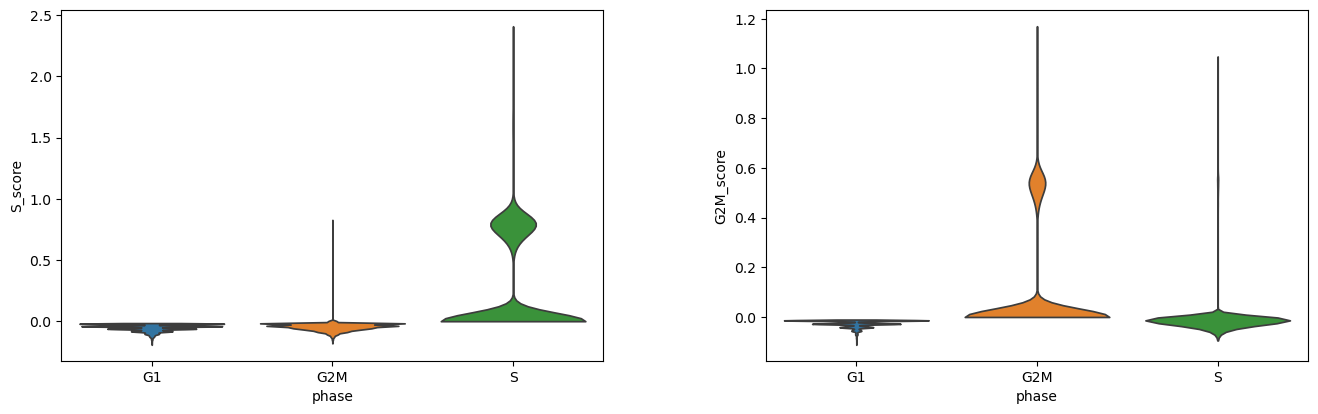

In [37]:
sc.pl.violin(ST_sample, ['S_score','G2M_score'], groupby='phase', jitter=0.4, size=0)

In [29]:
 # Regress out total_counts (and mt%) **per gene**
# sc.pp.regress_out(
#     ST_sample,
#     keys=['total_counts', 'pct_counts_mito']  # choose one or more covariates
# )

sc.pp.regress_out(
    ST_sample,
    keys=['total_counts', 'pct_counts_mito', 'S_score', 'G2M_score']
)

In [30]:
 # Scale so each gene has unit variance
sc.pp.scale(ST_sample, max_value=10)

sc.tl.pca(ST_sample, n_comps=15)
# sc.pp.neighbors(ST_sample, n_neighbors=15, n_pcs=15)

sc.pp.neighbors(
    ST_sample,
    n_neighbors=15,        # Lower = more asymmetry
    method='umap',         # Default graph construction method
    knn=True               # Ensures k-nearest neighbor graph (as opposed to full distance matrix)
)

In [31]:
sc.tl.leiden(
    ST_sample,
    resolution=0.6,
    flavor="leidenalg",
    directed=False,    # Undirected - forces a two way link
    n_iterations=2,
    random_state=1337
)

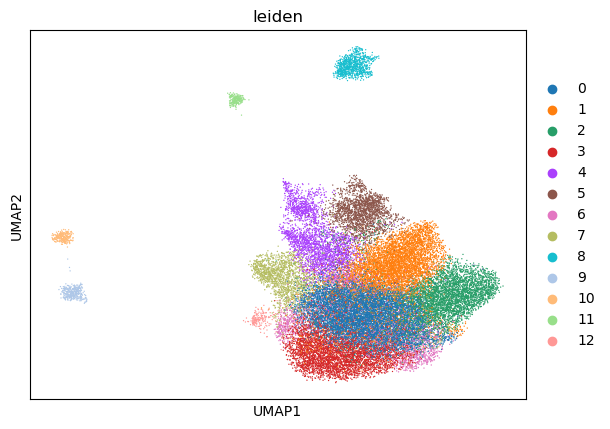

In [34]:
sc.settings.figdir = "/mnt/c/Users/jonan/Documents/1Work/RoseLab/Spatial/dietary_droject/data/cell_segmentation/SegmentedData/F07833/figures"
sc.tl.umap(ST_sample)
sc.pl.umap(ST_sample, color='leiden', save="_cell_cycle.png")


In [46]:
import scanpy as sc
import pandas as pd

# 1) Make sure you’ve clustered and have a 'leiden' (or other) column in adata.obs
#    e.g. adata.obs['leiden'] contains cluster assignments.

# 2) Run differential expression for all clusters at once
sc.tl.rank_genes_groups(
    ST_sample,
    groupby='leiden',        # column in adata.obs to test
    method='wilcoxon',       # or 't-test', 'logreg'
    pts=True,                # compute fraction of cells expressing the gene
    key_added='rank_genes'   # name for the result in adata.uns
)

# 3) Extract the top N genes for a specific cluster (e.g. cluster '2')
cluster = '11'
top_n = 40

# Option A: use the helper to get a DataFrame
deg_df = sc.get.rank_genes_groups_df(
    ST_sample,
    group=cluster,
    key='rank_genes'   # matches key_added above
)
top_deg = deg_df.head(top_n)
print(top_deg)

# Option B: manually pull from adata.uns
uns = ST_sample.uns['rank_genes']
genes = uns['names'][cluster][:top_n]
logfc = uns['logfoldchanges'][cluster][:top_n]
pvals = uns['pvals_adj'][cluster][:top_n]
pct1  = uns['pts'][cluster][:top_n]       # pct expressing in cluster
pct2  = uns['pts_rest'][cluster][:top_n]  # pct in other cells

top_deg_manual = pd.DataFrame({
    'gene': genes,
    'log2FC': logfc,
    'pval_adj': pvals,
    'pct_cluster': pct1,
    'pct_rest': pct2
})
print(top_deg_manual)


        names     scores  logfoldchanges          pvals      pvals_adj  \
0        Cbx5  25.660482             NaN  3.229789e-145  6.459579e-142   
1       Atp4a  24.899891             NaN  7.460277e-137  4.263015e-135   
2       Fabp6  24.897539             NaN  7.911231e-137  4.395128e-135   
3        Fmod  24.887213             NaN  1.023402e-136  5.101558e-135   
4     Emilin2  24.881941             NaN  1.167121e-136  5.557717e-135   
5   Hist1h2bh  24.877941             NaN  1.289458e-136  5.997477e-135   
6       Tiam2  24.876677             NaN  1.330751e-136  6.048866e-135   
7       Cwc22  24.872421             NaN  1.479556e-136  6.575806e-135   
8       Tgfbi  24.849628       -1.377777  2.609836e-136  1.043934e-134   
9      Dennd3  24.841558             NaN  3.190365e-136  1.237029e-134   
10     Col6a1  24.841234             NaN  3.216276e-136  1.237029e-134   
11     Ccdc15  24.832668             NaN  3.980111e-136  1.501929e-134   
12     Cldn11  24.827841             N

/home/jon/anaconda3/envs/spatial_analysis/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/jon/anaconda3/envs/spatial_analysis/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/jon/anaconda3/envs/spatial_analysis/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/jon/anaconda3/envs/spatial_analysis/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/jon/anaconda3/envs/spatial_analysis/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value

In [44]:
import scanpy as sc
import pandas as pd

# 1) Make sure you’ve clustered and have a 'leiden' (or other) column in adata.obs
#    e.g. adata.obs['leiden'] contains cluster assignments.

# 2) Run differential expression for all clusters at once
sc.tl.rank_genes_groups(
    ST_sample,
    groupby='leiden',        # column in adata.obs to test
    method='wilcoxon',       # or 't-test', 'logreg'
    pts=True,                # compute fraction of cells expressing the gene
    key_added='rank_genes'   # name for the result in adata.uns
)

# 3) Extract the top N genes for a specific cluster (e.g. cluster '2')
cluster = '8'
top_n = 20

# Option A: use the helper to get a DataFrame
deg_df = sc.get.rank_genes_groups_df(
    ST_sample,
    group=cluster,
    key='rank_genes'   # matches key_added above
)
top_deg = deg_df.head(top_n)
print(top_deg)

# Option B: manually pull from adata.uns
uns = ST_sample.uns['rank_genes']
genes = uns['names'][cluster][:top_n]
logfc = uns['logfoldchanges'][cluster][:top_n]
pvals = uns['pvals_adj'][cluster][:top_n]
pct1  = uns['pts'][cluster][:top_n]       # pct expressing in cluster
pct2  = uns['pts_rest'][cluster][:top_n]  # pct in other cells

top_deg_manual = pd.DataFrame({
    'gene': genes,
    'log2FC': logfc,
    'pval_adj': pvals,
    'pct_cluster': pct1,
    'pct_rest': pct2
})
print(top_deg_manual)


       names     scores  logfoldchanges  pvals  pvals_adj  pct_nz_group  \
0       Rrm2  50.306000             NaN    0.0        0.0           1.0   
1       Etv1  49.216858             NaN    0.0        0.0           1.0   
2     Krt222  49.208439             NaN    0.0        0.0           1.0   
3     Cyp7a1  49.146011       -3.665254    0.0        0.0           1.0   
4       Cd28  49.122765             NaN    0.0        0.0           1.0   
5    Dnajc18  49.076443       -1.327248    0.0        0.0           1.0   
6      Pomt2  49.050774       -0.038619    0.0        0.0           1.0   
7     Sfmbt1  49.008339             NaN    0.0        0.0           1.0   
8    Zdhhc17  49.008053       -0.294527    0.0        0.0           1.0   
9      Klf16  49.004391       -3.345514    0.0        0.0           1.0   
10    Supt7l  49.003799       -0.910270    0.0        0.0           1.0   
11      Iqcc  49.003613             NaN    0.0        0.0           1.0   
12  Slc25a43  48.980606  

/home/jon/anaconda3/envs/spatial_analysis/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/jon/anaconda3/envs/spatial_analysis/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/jon/anaconda3/envs/spatial_analysis/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/jon/anaconda3/envs/spatial_analysis/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/jon/anaconda3/envs/spatial_analysis/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value


# Batch Testing

In [ ]:
# Make figures of umi side by side in umap

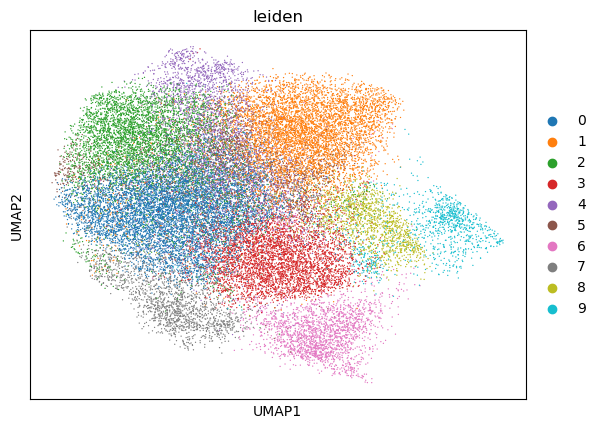

In [40]:
sc.settings.figdir = "/mnt/c/Users/jonan/Documents/1Work/RoseLab/Spatial/dietary_droject/data/cell_segmentation/SegmentedData/F07833/figures"

# Run Leiden clustering and UMAP
sc.tl.leiden(ST_sample, resolution=0.6)
sc.tl.umap(ST_sample)

# Save the UMAP plot
sc.pl.umap(ST_sample, color='leiden', save="_leiden_umap.png")

In [21]:
list(range(5, 31, 5))

[5, 10, 15, 20, 25, 30]

In [31]:
for pcs in list(range(5, 31, 5)):
    sc.tl.pca(ST_sample, n_comps=pcs)
    sc.pp.neighbors(ST_sample, n_neighbors=15, n_pcs=pcs)
    sc.tl.leiden(ST_sample, resolution=0.5, key_added=f'leiden_pcs{pcs}')

sc.pl.umap(ST_sample, color=['leiden_pcs5', 'leiden_pcs20'])

KeyError: "Could not find 'umap' or 'X_umap' in .obsm"

# 1. Remove obvious empty / low-quality cells

# used ESC and M to change to markdown
sc.pp.filter_cells(ST_sample, min_counts=30)        # keep lenient cut-off
ST_sample = ST_sample[ST_sample.obs['total_counts'] >= 70]  # or keep everything & model depth later
sc.pp.filter_genes(ST_sample, min_cells=3)
# 2. scran size‑factor pooling via rpy2 (works well at 50–200 UMIs)

pandas2ri.activate()
ro.r('library(scran); sce <- as.SingleCellExperiment(as.matrix(ad))')
ro.r('sce <- computeSumFactors(sce); sizef <- sizeFactors(sce)')
ST_sample.obs['size_factors'] = np.array(ro.r('sizef'))
sc.pp.normalize_total(ST_sample, target_sum=1e6, key_added="size_factors")

# 3. Choose one of the transforms
sc.experimental.pp.recipe_pearson_residuals(ST_sample)  # or SCTransform / MAGIC

# 4. Dimensionality reduction & Leiden
sc.tl.pca(ST_sample, n_comps=30)
sc.pp.neighbors(ST_sample, n_neighbors=20, n_pcs=30)
sc.tl.leiden(ST_sample, resolution=0.4)
sc.tl.umap(ST_sample); sc.pl.umap(ST_sample, color='leiden')

# === 2. Compute scran size factors ===
# Convert to gene x cell matrix (scran expects this orientation)
counts = ST_sample.X.toarray() if issparse(ST_sample.X) else ST_sample.X
counts_df = pd.DataFrame(counts.T, index=ST_sample.var_names, columns=ST_sample.obs_names)
ro.globalenv['counts'] = counts_df

# Run scran in R via rpy2
ro.r('''
library(SingleCellExperiment)
library(scran)
sce <- SingleCellExperiment(list(counts = as.matrix(counts)))
sce <- computeSumFactors(sce)
sizef <- sizeFactors(sce)
''')

# Get size factors from R and assign to obs
sizef = np.array(ro.r('sizef'))
ST_sample.obs['size_factors'] = sizef

# === 3. Apply scran normalization ===
ST_sample.layers["counts"] = ST_sample.X.copy()  # Preserve raw counts
ST_sample.X = ST_sample.X.multiply(1 / sizef[:, None]) if issparse(ST_sample.X) else ST_sample.X / sizef[:, None]

# === 4. Variance stabilization ===
sc.experimental.pp.recipe_pearson_residuals(ST_sample)

# === 5. Dimensionality reduction and clustering ===
sc.tl.pca(ST_sample, n_comps=30)
sc.pp.neighbors(ST_sample, n_neighbors=20, n_pcs=30)
sc.tl.leiden(ST_sample, resolution=0.4)

# === 6. Visualization ===
sc.tl.umap(ST_sample)
sc.pl.umap(ST_sample, color='leiden')

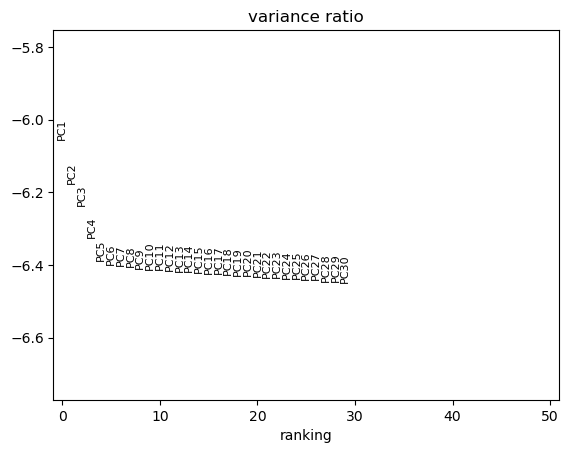

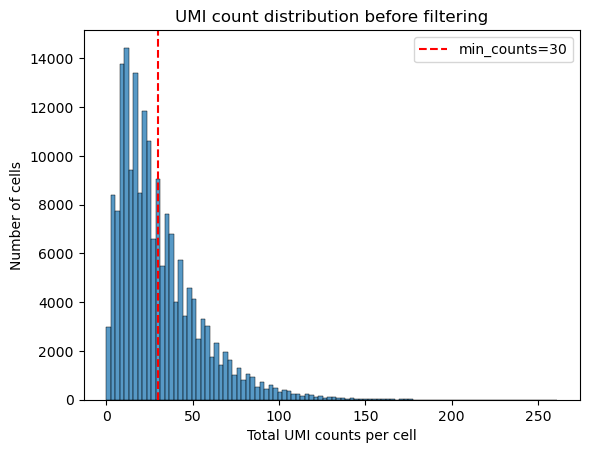

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(ST_sample.obs['total_counts'], bins=100)
plt.axvline(30, color='red', linestyle='--', label='min_counts=30')
plt.xlabel('Total UMI counts per cell')
plt.ylabel('Number of cells')
plt.legend()
plt.title('UMI count distribution before filtering')
plt.show()

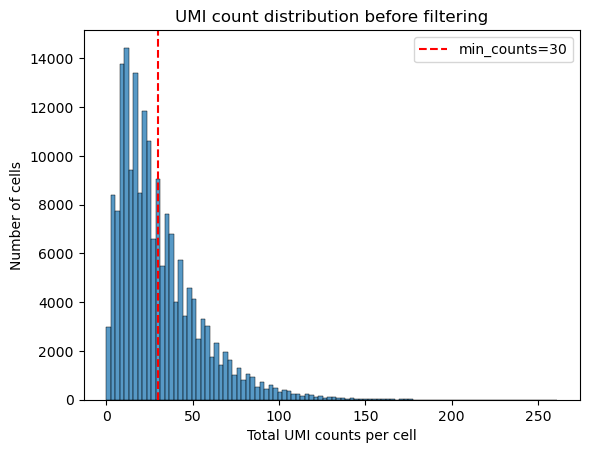

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(ST_sample.obs['total_counts'], bins=100)
plt.axvline(30, color='red', linestyle='--', label='min_counts=30')
plt.xlabel('Total UMI counts per cell')
plt.ylabel('Number of cells')
plt.legend()
plt.title('UMI count distribution before filtering')
plt.show()

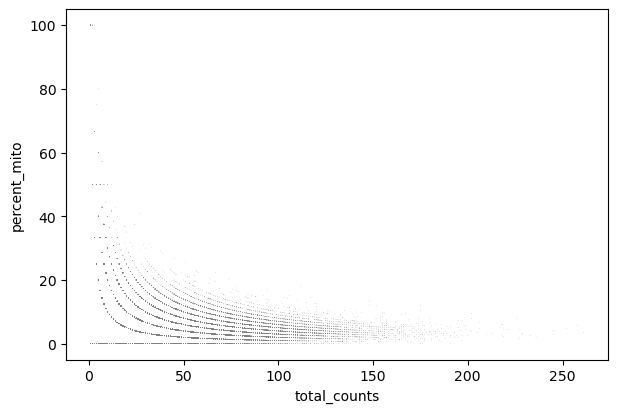

In [25]:
sc.pl.scatter(ST_sample, x='total_counts', y='percent_mito')

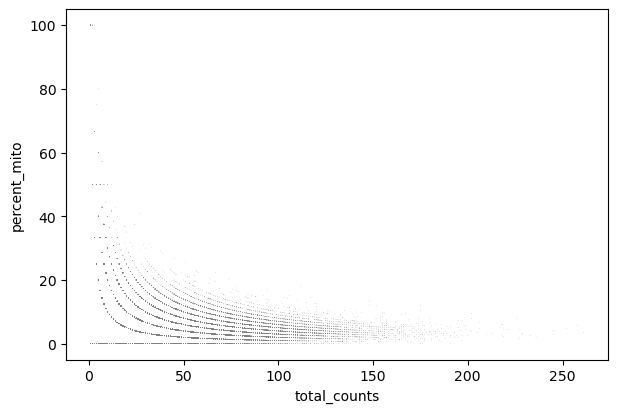

In [25]:
sc.pl.scatter(ST_sample, x='total_counts', y='percent_mito')